In [1]:
from matplotlib import pyplot as plt
import numpy as np
import math
import numpy as np
from sklearn import datasets
import copy

In [2]:
# Support Vector Machine
def SVM(X,Y,C):
    #step 1: 构造SVM的凸二次规划问题
    data_num = X.shape[0]
    kernel_data = np.zeros([data_num, data_num])

    hessian = np.zeros([data_num, data_num]) # 二次项矩阵
    r = np.ones((data_num, 1)) * -1  # 一次项矩阵
    G = np.diag(np.ones(data_num) * -1)  # 等式约束项系数
    h = np.zeros((data_num, 1))  # 等式约束项常数
    A = np.zeros([1, data_num])
    b = np.zeros((1, 1))

    #核函数映射
    for i in range(data_num):
        A[0][i] = Y[i]
        for j in range(data_num):
            # 核函数的选取
            kernel_data[i][j] = kernel_function(X[i], X[j],type = KERNEL)
            # kerMat[i][j] = np.dot(X[i], X[j])
            hessian[i][j] = kernel_data[i][j] * Y[i] * Y[j]
    # print(kernel_data.shape)
    # print(hessian.shape)
    # print(hessian)

    # step 2: 使用ActiveSet求解
    count = 0
    for i in range(data_num):
        if (Y[i] == 1):
            count += 1
    # ActiveSet初始参数x0
    x0 = np.ones((data_num, 1))
    for i in range(data_num):
        if Y[i] == 1:
            x0[i][0] = data_num - count
        else:
            x0[i][0] = count
    solution, lamb = ASM(x0, hessian, r, G, h, A, b)

    # step 3: 选取0<alpha<C, support_vector
    a = np.ravel(solution)
    # find  ECQP multipliers larger than zero,  Support vectors have non zero lagrange multipliers
    sv = a > 1e-5
    for i in range(X.shape[0]):
        if a[i] > C:
            sv[i] = False
    ind = np.arange(len(a))[sv]
    alpha = a[sv]
    supportData = X[sv]
    supportLabel = Y[sv]
    intercept = 0
    for i in range(len(alpha)):
        intercept += supportLabel[i]
        intercept -= np.sum(alpha * supportLabel * kernel_data[ind[i], sv])
    intercept /= len(alpha)
    return alpha, supportData, supportLabel, intercept

# Active Set Method
def ASM(x0, hessian, r, G, h, A, b):
    # Step 1: 构建有效集zeroIdx
    zeroIdx = []
    if A.shape[0] == len(x0):
        rowA, colA = A.shape
    else:
        rowA = 0
    rowG, colG = G.shape

    sum = np.dot(G, x0)
    tmp = sum - h
    for i in range(rowG):
        if abs(tmp[i])<1e-5:
            zeroIdx.append(i)
    step = 0

    x = x0
    while step < 100:
        # Step 2 构造子命题，通过
        r_new = hessian.dot(x) + r
        A_new = np.zeros((rowA + len(zeroIdx), colG))
        b_new = np.zeros((rowA + len(zeroIdx), 1))
        for i in range(rowA):
            for j in range(colG):
                A_new[i][j] = A[i][j]
        count = 0
        for i in zeroIdx:
            for j in range(colG):
                A_new[rowA + count][j] = G[i][j]
            count += 1
        # 二次规划，求移动的方向d
        d, lamb = QP(hessian, r_new, A_new, b_new)

        # Step 3 如果d=0，d为最优解；
        is_zero_vector = True
        if np.linalg.norm(d) > 1e-5:
            is_zero_vector = False
        if is_zero_vector:
            isOpt = True
            idxMin = np.argmin(lamb)
            lambMin = lamb[idxMin]
            #对应于有效约束的乘子lamb>0,则为最优点；否则从有效集中去除
            if lambMin < 0:
                isOpt = False

            if isOpt:
                output = np.zeros((rowG, 1))
                shift = 0
                for i in zeroIdx:
                    output[i][0] = lamb[shift]
                    shift += 1
                return x, output
                break
            else:
                zeroIdx.remove(idxMin)
            step += 1
        else:
            # Step 4 如果d!=0，确定步长alpha，更新迭代点
            alpha = 1.
            idxMin = -1
            for i in range(rowG):
                if zeroIdx.count(i) == 0:
                    k = (h[i][0] - G[i].T.dot(x)) / (G[i].T.dot(d))
                    if k <= alpha and G[i].dot(d) > 0:
                        idxMin = i
                        alpha = k
            x = x + alpha * d
            if idxMin != -1:
                zeroIdx.append(idxMin)
            step += 1
    return x, lamb

def IsZeroVec(Vec):
    for i in range(len(Vec)):
        if not(IsZero(Vec[i])):
            return False
    return True

def QP(G, h, A, b):
    rowA, colA = A.shape
    left = np.vstack((G, A))
    right = np.vstack((A.T, np.zeros((rowA, rowA))))
    x = np.linalg.solve(np.hstack((left, right)), np.vstack((-h, b)))
    solution = x[:colA]
    lamb = x[colA:]
    return solution, lamb

# 核函数
def kernel_function(x,y,type):
    if type == 0:#linear
        kernel = x.dot(np.transpose(y))
    if type == 1:#gaussian
        sigma = 0.5
        kernel = np.exp(-np.linalg.norm(x - y) / sigma)
    return kernel


# 模型预测
def predict(x, alpha, suppData, suppLab, intercept):
    return np.sign(project(x, alpha, suppData, suppLab, intercept))

def project(x, alpha, suppData, suppLab, intercept):
    y_predict = np.zeros(len(x))
    for i in range(len(x)):
        s = 0
        for a, data, y in zip(alpha, suppData, suppLab):
            s += a * y * kernel_function(x[i], data, type = KERNEL)
        y_predict[i] = s
    return (y_predict + intercept)


# 结果绘制
def plot_result(x1_train, x2_train, alpha, suppLab, suppData, grid_half_len=8):
    plt.plot(x1_train[:, 0], x1_train[:, 1], "r+")
    plt.plot(x2_train[:, 0], x2_train[:, 1], "b.")
    x1, x2 = np.meshgrid(np.linspace(-grid_half_len, grid_half_len, 100),
                         np.linspace(-grid_half_len, grid_half_len, 100))
    x = np.array([[x1, x2] for x1, x2 in zip(np.ravel(x1), np.ravel(x2))])
    Z = project(x, alpha, suppData, suppLab, intercept).reshape(x1.shape)
    plt.contour(x1, x2, Z, [0.0], colors='k', linewidths=1)
    plt.show()

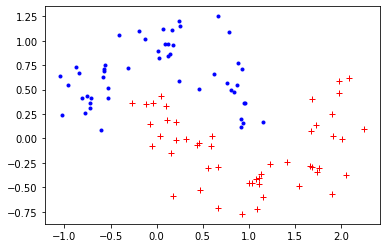

In [4]:
#制作线性分类器无法分开的数据集
X, y = datasets.make_moons(n_samples=100, noise=0.2)
y[y==0]=-1

plt.plot(X[y == 1][:, 0], X[y == 1][:, 1], "r+")
plt.plot(X[y == -1][:, 0], X[y == -1][:, 1], "b.")
plt.show()

SVM Precision:0.82


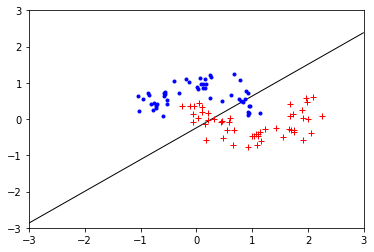

In [12]:
#选取线性核函数，0-线性核，1-高斯核
KERNEL = 0
C = 10

#SVM主函数
alpha, suppData, suppLab, intercept = SVM(X,y,C)

#分类决策函数
Y_predict = predict(X, alpha, suppData, suppLab, intercept)
precision = np.sum(Y_predict == y) / len(y)
print("SVM Precision:" + str(precision))

plot_result(X[y == 1], X[y == -1], alpha, suppLab, suppData, 3)

SVM Precision:1.0


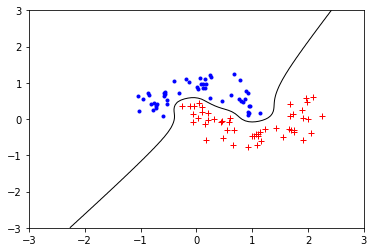

In [13]:
#选取高斯核函数，0-线性核，1-高斯核
KERNEL = 1
C = 10

#SVM主函数
alpha, suppData, suppLab, intercept = SVM(X,y,C)

#分类决策函数
Y_predict = predict(X, alpha, suppData, suppLab, intercept)
precision = np.sum(Y_predict == y) / len(y)
print("SVM Precision:" + str(precision))

plot_result(X[y == 1], X[y == -1], alpha, suppLab, suppData, 3)